In [1]:
import sys
import os

# Add Codes/src to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src')))

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

from plot_utils import plot_comparison_boxplots
from train_utils import BatteryTrainerBase, BatterySeqDataset, build_lstm_sequences, pad_collate_fn


In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
df = pd.read_pickle('../../../Datasets/processed/merged_interp_flat.pkl')
df.head()

,cell_id,rated_capacity,cycle_index,capacity,soh,dqdt_min,dqdt_max,dqdt_mean,dqdt_std,dvdt_min,...,i_interp_991,i_interp_992,i_interp_993,i_interp_994,i_interp_995,i_interp_996,i_interp_997,i_interp_998,i_interp_999,source
0,B0005,2.0,1,1.856487,0.928244,-1.332504e-07,0.002876,0.000528,0.000255,-0.006229,...,0.004819,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,nasa
1,B0005,2.0,3,1.846327,0.923164,-4.510385e-07,0.002894,0.000527,0.000257,-0.006004,...,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,nasa
2,B0005,2.0,5,1.835349,0.917675,-1.163391e-07,0.002333,0.000520,0.000227,-0.005953,...,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,nasa
3,B0005,2.0,7,1.835263,0.917631,-2.062661e-07,0.002885,0.000530,0.000255,-0.005907,...,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,nasa
4,B0005,2.0,9,1.834646,0.917323,-5.353266e-07,0.002896,0.000530,0.000256,-0.005923,...,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,nasa


In [5]:
import torch.nn as nn
from torch.utils.data import TensorDataset


class BatteryFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, dropout=0.0):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)]
        layers += [nn.Linear(hidden_dim, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [6]:
class BatteryTrainer(BatteryTrainerBase):
    def train(self, train_df, val_df, feature_cols=None, epochs=20, **model_kwargs):
        X_train = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
        y_train = torch.tensor(train_df[self.target_cols[0]].values, dtype=torch.float32).unsqueeze(1)
        X_val = torch.tensor(val_df[feature_cols].values, dtype=torch.float32)
        y_val = torch.tensor(val_df[self.target_cols[0]].values, dtype=torch.float32).unsqueeze(1)

        train_loader = DataLoader(
            TensorDataset(X_train, y_train),
            batch_size=model_kwargs.get("batch_size", 32),
            shuffle=True
        )

        val_loader = DataLoader(
            TensorDataset(X_val, y_val),
            batch_size=model_kwargs.get("batch_size", 32)
        )

        model = BatteryFFNN(
            input_dim=len(feature_cols),
            hidden_dim=model_kwargs.get("hidden_dim", 128),
            num_layers=model_kwargs.get("num_layers", 2),
            dropout=model_kwargs.get("dropout", 0.0)
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=model_kwargs.get("lr", 1e-3))
        criterion = nn.MSELoss()

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                pred = model(xb)
                loss = criterion(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                val_preds.append(pred.numpy())
                val_targets.append(yb.numpy())

        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)

        print(f"FFNN Val MSE={mean_squared_error(val_targets, val_preds):.4f}, MAE={mean_absolute_error(val_targets, val_preds):.4f}, R²={r2_score(val_targets, val_preds):.4f}")
        return model, val_targets, val_preds

    def optuna_objective(self, trial):
        hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
        num_layers = trial.suggest_int("num_layers", 1, 2)
        dropout = trial.suggest_float("dropout", 0.0, 0.1, step=0.1)
        lr = trial.suggest_categorical("lr", [1e-2, 1e-3, 1e-4])   
        batch_size = trial.suggest_categorical("batch_size", [18, 32, 64])

        result = self.cross_validate(
            lr=lr,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_size=batch_size
        )

         # for robust
        std_mse = np.std(result.mse)
        score = result.avg_mse + 0.8 * std_mse # we can tune the weight

        return score


In [7]:
trainer = BatteryTrainer(df, target_cols=['soh'])

In [8]:
trainer.cross_validate()


=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0025, MAE=0.0328, R²=0.9396
  MSE: 0.0025, MAE: 0.0328, R²: 0.9396

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0111, MAE=0.0576, R²=0.6757
  MSE: 0.0111, MAE: 0.0576, R²: 0.6757

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0021, MAE=0.0282, R²=0.9534
  MSE: 0.0021, MAE: 0.0282, R²: 0.9534

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0010, MAE=0.0177, R²=0.9744
  MSE: 0.0010, MAE: 0.0177, R²: 0.9744

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0019, MAE=0.0235, R²=0.9728
  MSE: 0.0019, MAE: 0.0235, R²: 0.9728

=== Avera

CVResult(mse=[0.0025165434926748276, 0.01109788566827774, 0.0020514484494924545, 0.0009503759793005884, 0.001862677512690425], mae=[0.03282921388745308, 0.05763852223753929, 0.028173500671982765, 0.01770527847111225, 0.02351008541882038], r2=[0.9396039843559265, 0.6756517887115479, 0.953423261642456, 0.9743651747703552, 0.9727512001991272], avg_mse=0.003695786220487207, avg_mae=0.031971320137381555, avg_r2=0.9031590819358826)

In [9]:
study = trainer.run_optuna_tuning()

[I 2025-04-17 15:11:55,850] A new study created in memory with name: no-name-c0b93d02-41a4-4dff-8933-5f532a6fca3d



=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0029, MAE=0.0320, R²=0.9297
  MSE: 0.0029, MAE: 0.0320, R²: 0.9297

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0284, MAE=0.0740, R²=0.1698
  MSE: 0.0284, MAE: 0.0740, R²: 0.1698

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0035, MAE=0.0357, R²=0.9198
  MSE: 0.0035, MAE: 0.0357, R²: 0.9198

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0017, MAE=0.0299, R²=0.9544
  MSE: 0.0017, MAE: 0.0299, R²: 0.9544

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


[I 2025-04-17 15:12:57,684] Trial 0 finished with value: 0.016119696426089007 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.0001, 'batch_size': 32}. Best is trial 0 with value: 0.016119696426089007.


FFNN Val MSE=0.0030, MAE=0.0349, R²=0.9566
  MSE: 0.0030, MAE: 0.0349, R²: 0.9566

=== Average CV Performance ===
Avg MSE: 0.0079
Avg MAE: 0.0413
Avg R² : 0.7861

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0030, MAE=0.0310, R²=0.9286
  MSE: 0.0030, MAE: 0.0310, R²: 0.9286

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0104, MAE=0.0463, R²=0.6963
  MSE: 0.0104, MAE: 0.0463, R²: 0.6963

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0039, MAE=0.0457, R²=0.9112
  MSE: 0.0039, MAE: 0.0457, R²: 0.9112

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0020, MAE=0.0320, R²=0.9459
  MSE: 0.0020, MAE: 0.0320, R²: 0.9459

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 15:13:45,967] Trial 1 finished with value: 0.00688037533826405 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32}. Best is trial 1 with value: 0.00688037533826405.


FFNN Val MSE=0.0030, MAE=0.0334, R²=0.9560
  MSE: 0.0030, MAE: 0.0334, R²: 0.9560

=== Average CV Performance ===
Avg MSE: 0.0045
Avg MAE: 0.0377
Avg R² : 0.8876

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0032, MAE=0.0352, R²=0.9234
  MSE: 0.0032, MAE: 0.0352, R²: 0.9234

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0098, MAE=0.0568, R²=0.7143
  MSE: 0.0098, MAE: 0.0568, R²: 0.7143

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0019, MAE=0.0281, R²=0.9577
  MSE: 0.0019, MAE: 0.0281, R²: 0.9577

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0021, MAE=0.0268, R²=0.9441
  MSE: 0.0021, MAE: 0.0268, R²: 0.9441

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 15:15:33,668] Trial 2 finished with value: 0.006513513594022536 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 18}. Best is trial 2 with value: 0.006513513594022536.


FFNN Val MSE=0.0041, MAE=0.0381, R²=0.9407
  MSE: 0.0041, MAE: 0.0381, R²: 0.9407

=== Average CV Performance ===
Avg MSE: 0.0042
Avg MAE: 0.0370
Avg R² : 0.8960

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0032, MAE=0.0338, R²=0.9228
  MSE: 0.0032, MAE: 0.0338, R²: 0.9228

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0566, MAE=0.1371, R²=-0.6536
  MSE: 0.0566, MAE: 0.1371, R²: -0.6536

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0054, MAE=0.0548, R²=0.8769
  MSE: 0.0054, MAE: 0.0548, R²: 0.8769

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0021, MAE=0.0287, R²=0.9434
  MSE: 0.0021, MAE: 0.0287, R²: 0.9434

=== Fold 5 ===
[nasa] Normalizing 2014 feat

[I 2025-04-17 15:16:12,876] Trial 3 finished with value: 0.031101470007897265 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.01, 'batch_size': 64}. Best is trial 2 with value: 0.006513513594022536.


FFNN Val MSE=0.0031, MAE=0.0382, R²=0.9551
  MSE: 0.0031, MAE: 0.0382, R²: 0.9551

=== Average CV Performance ===
Avg MSE: 0.0141
Avg MAE: 0.0585
Avg R² : 0.6089

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0035, MAE=0.0366, R²=0.9151
  MSE: 0.0035, MAE: 0.0366, R²: 0.9151

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0138, MAE=0.0510, R²=0.5962
  MSE: 0.0138, MAE: 0.0510, R²: 0.5962

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0021, MAE=0.0299, R²=0.9525
  MSE: 0.0021, MAE: 0.0299, R²: 0.9525

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0023, MAE=0.0359, R²=0.9386
  MSE: 0.0023, MAE: 0.0359, R²: 0.9386

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 15:17:32,471] Trial 4 finished with value: 0.008955629831988152 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 18}. Best is trial 2 with value: 0.006513513594022536.


FFNN Val MSE=0.0056, MAE=0.0450, R²=0.9178
  MSE: 0.0056, MAE: 0.0450, R²: 0.9178

=== Average CV Performance ===
Avg MSE: 0.0055
Avg MAE: 0.0397
Avg R² : 0.8641

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0251, MAE=0.1127, R²=0.3985
  MSE: 0.0251, MAE: 0.1127, R²: 0.3985

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0479, MAE=0.1268, R²=-0.4010
  MSE: 0.0479, MAE: 0.1268, R²: -0.4010

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0231, MAE=0.1048, R²=0.4755
  MSE: 0.0231, MAE: 0.1048, R²: 0.4755

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0149, MAE=0.0917, R²=0.5972
  MSE: 0.0149, MAE: 0.0917, R²: 0.5972

=== Fold 5 ===
[nasa] Normalizing 2014 feat

[I 2025-04-17 15:18:12,388] Trial 5 finished with value: 0.03499915844411393 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'batch_size': 64}. Best is trial 2 with value: 0.006513513594022536.


FFNN Val MSE=0.0167, MAE=0.0974, R²=0.7563
  MSE: 0.0167, MAE: 0.0974, R²: 0.7563

=== Average CV Performance ===
Avg MSE: 0.0255
Avg MAE: 0.1067
Avg R² : 0.3653

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0037, MAE=0.0397, R²=0.9107
  MSE: 0.0037, MAE: 0.0397, R²: 0.9107

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0116, MAE=0.0668, R²=0.6605
  MSE: 0.0116, MAE: 0.0668, R²: 0.6605

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0064, MAE=0.0585, R²=0.8550
  MSE: 0.0064, MAE: 0.0585, R²: 0.8550

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0030, MAE=0.0399, R²=0.9192
  MSE: 0.0030, MAE: 0.0399, R²: 0.9192

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 15:19:00,931] Trial 6 finished with value: 0.008193288718552438 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.0001, 'batch_size': 64}. Best is trial 2 with value: 0.006513513594022536.


FFNN Val MSE=0.0033, MAE=0.0363, R²=0.9520
  MSE: 0.0033, MAE: 0.0363, R²: 0.9520

=== Average CV Performance ===
Avg MSE: 0.0056
Avg MAE: 0.0482
Avg R² : 0.8595

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0418, MAE=0.1706, R²=-0.0023
  MSE: 0.0418, MAE: 0.1706, R²: -0.0023

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0206, MAE=0.1036, R²=0.3974
  MSE: 0.0206, MAE: 0.1036, R²: 0.3974

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0214, MAE=0.0950, R²=0.5130
  MSE: 0.0214, MAE: 0.0950, R²: 0.5130

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0129, MAE=0.0810, R²=0.6529
  MSE: 0.0129, MAE: 0.0810, R²: 0.6529

=== Fold 5 ===
[nasa] Normalizing 2014 feat

[I 2025-04-17 15:20:03,285] Trial 7 finished with value: 0.03712874491379073 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.01, 'batch_size': 32}. Best is trial 2 with value: 0.006513513594022536.


FFNN Val MSE=0.0416, MAE=0.1128, R²=0.3914
  MSE: 0.0416, MAE: 0.1128, R²: 0.3914

=== Average CV Performance ===
Avg MSE: 0.0277
Avg MAE: 0.1126
Avg R² : 0.3905

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0059, MAE=0.0513, R²=0.8586
  MSE: 0.0059, MAE: 0.0513, R²: 0.8586

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0044, MAE=0.0438, R²=0.8707
  MSE: 0.0044, MAE: 0.0438, R²: 0.8707

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0028, MAE=0.0364, R²=0.9373
  MSE: 0.0028, MAE: 0.0364, R²: 0.9373

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0022, MAE=0.0348, R²=0.9401
  MSE: 0.0022, MAE: 0.0348, R²: 0.9401

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 15:21:18,570] Trial 8 finished with value: 0.004686914972198652 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 18}. Best is trial 8 with value: 0.004686914972198652.


FFNN Val MSE=0.0026, MAE=0.0331, R²=0.9615
  MSE: 0.0026, MAE: 0.0331, R²: 0.9615

=== Average CV Performance ===
Avg MSE: 0.0036
Avg MAE: 0.0399
Avg R² : 0.9136

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0503, MAE=0.1667, R²=-0.2065
  MSE: 0.0503, MAE: 0.1667, R²: -0.2065

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0542, MAE=0.1441, R²=-0.5831
  MSE: 0.0542, MAE: 0.1441, R²: -0.5831

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.3366, MAE=0.3702, R²=-6.6414
  MSE: 0.3366, MAE: 0.3702, R²: -6.6414

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=33.1089, MAE=4.2553, R²=-892.0569
  MSE: 33.1089, MAE: 4.2553, R²: -892.0569

=== Fold 5 ===
[nasa] Normalizi

[I 2025-04-17 15:23:03,230] Trial 9 finished with value: 17.360182558282425 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.01, 'batch_size': 18}. Best is trial 8 with value: 0.004686914972198652.


FFNN Val MSE=0.7393, MAE=0.6163, R²=-9.8153
  MSE: 0.7393, MAE: 0.6163, R²: -9.8153

=== Average CV Performance ===
Avg MSE: 6.8578
Avg MAE: 1.1105
Avg R² : -181.8606

Best trial:
  MSE: 0.0047
  Params:
    hidden_dim: 64
    num_layers: 2
    dropout: 0.1
    lr: 0.001
    batch_size: 18


In [10]:
base_model = trainer.train_base_model()


Training base model with default hyperparameters
FFNN Val MSE=0.0015, MAE=0.0167, R²=0.9635


In [11]:
tuned_model = trainer.train_tuned_model()


Training with best Optuna params:
  hidden_dim: 64
  num_layers: 2
  dropout: 0.1
  lr: 0.001
  batch_size: 18
FFNN Val MSE=0.0034, MAE=0.0426, R²=0.9183



Running cross-validation for base model...

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0025, MAE=0.0284, R²=0.9395
  MSE: 0.0025, MAE: 0.0284, R²: 0.9395

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0375, MAE=0.0607, R²=-0.0962
  MSE: 0.0375, MAE: 0.0607, R²: -0.0962

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0040, MAE=0.0421, R²=0.9088
  MSE: 0.0040, MAE: 0.0421, R²: 0.9088

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0017, MAE=0.0261, R²=0.9539
  MSE: 0.0017, MAE: 0.0261, R²: 0.9539

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
FFNN Val MSE=0.0016, MAE=0.0230, R²=0.9767
  M

c:\Users\adien\OneDrive - PLN\1. MDS Study\Github\CS64-Capstone\Codes\src\plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
c:\Users\adien\OneDrive - PLN\1. MDS Study\Github\CS64-Capstone\Codes\src\plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
c:\Users\adien\OneDrive - PLN\1. MDS Study\Github\CS64-Capstone\Codes\src\plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same 

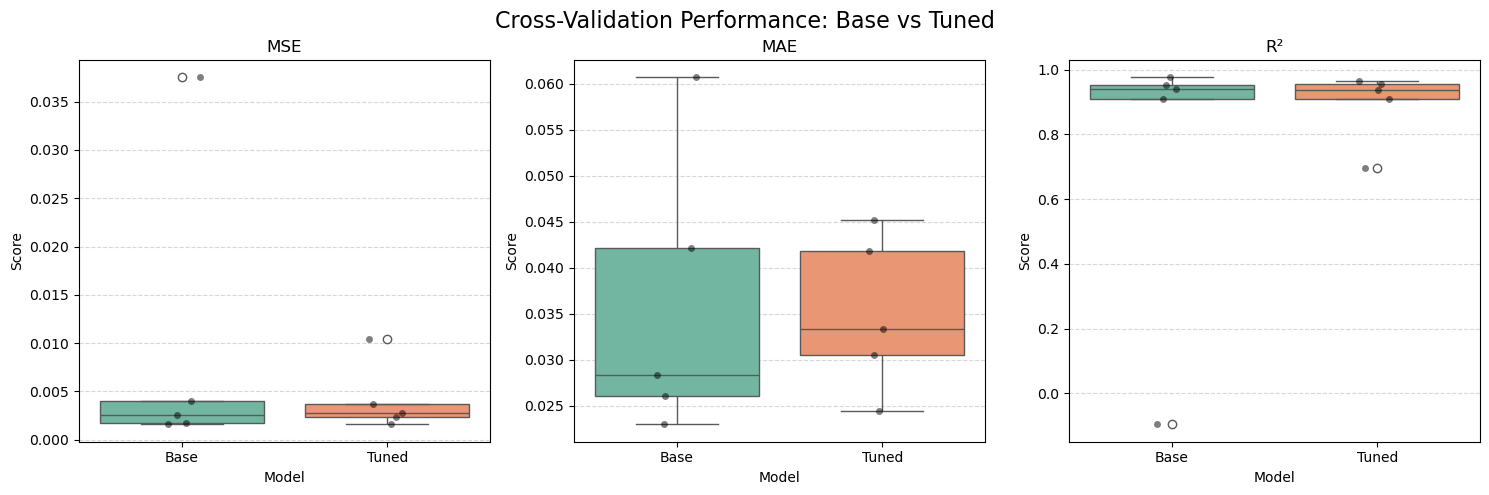

In [12]:
trainer.compare_base_vs_tuned_cv()